In [1]:
import os, math
from collections import defaultdict
import itertools
import sqlite3

import logging
import logging.handlers

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
RNG = np.random.default_rng()

In [3]:
x = RNG.integers(10, size=16).reshape(4,4)
x

array([[7, 0, 3, 8],
       [6, 4, 6, 9],
       [3, 5, 3, 8],
       [5, 2, 0, 8]])

In [4]:
xa1 = np.max(x, axis=1)
xa1

array([8, 9, 8, 8])

In [5]:
xa2 = np.sum(x, axis=1)
xa2

array([18, 25, 19, 15])

In [6]:
np.argsort(-xa1)

array([1, 0, 2, 3])

In [7]:
np.argsort(-xa2)

array([1, 2, 0, 3])

In [8]:
l = [10, 20, 10, 1, 2]
np.unique_counts(l)

UniqueCountsResult(values=array([ 1,  2, 10, 20]), counts=array([1, 1, 2, 1]))

In [9]:
v = 723
f'{v:5}'

'  723'

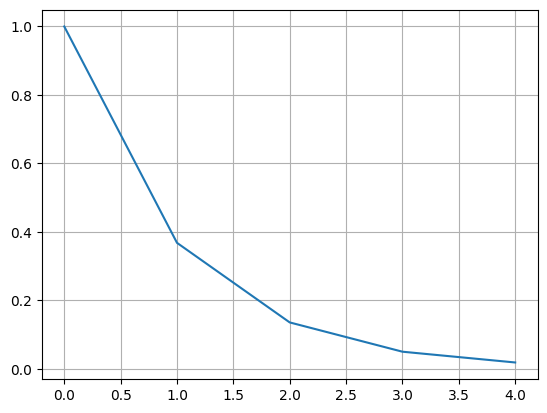

,x,y
0,0.0,1.000000
1,1.0,0.367879
2,2.0,0.135335
3,3.0,0.049787
4,4.0,0.018316


In [10]:
l = 1
xs = list(range(5))
ys = []
df = pd.DataFrame(columns=['x', 'y'])

for x in xs:
    y = l * np.exp(-l * x)
    ys.append(y)
    df.loc[len(df)] = [x, y]

plt.plot(xs, ys)
plt.grid()
plt.show()

df

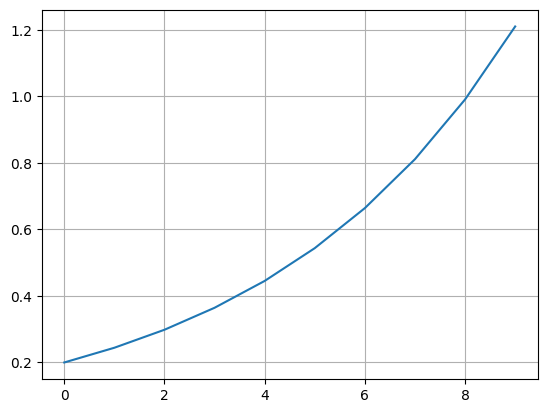

,x,y
0,0.0,0.200000
1,1.0,0.244281
2,2.0,0.298365
3,3.0,0.364424
4,4.0,0.445108
5,5.0,0.543656
6,6.0,0.664023
7,7.0,0.811040
8,8.0,0.990606
9,9.0,1.209929


In [11]:
l = 0.2
xs = list(range(10))
ys = []
df = pd.DataFrame(columns=['x', 'y'])

for x in xs:
    y = l * np.exp(l * x)
    ys.append(y)
    df.loc[len(df)] = [x, y]

plt.plot(xs, ys)
plt.grid()
plt.show()

df

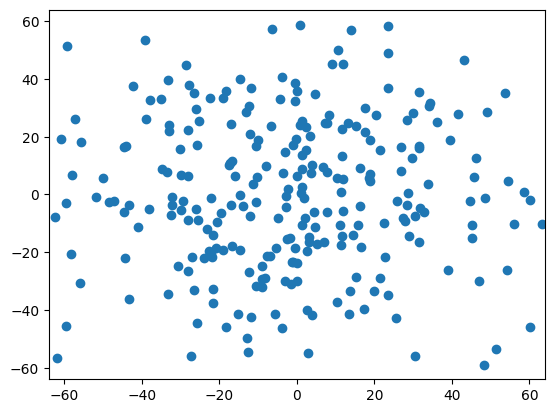

(256,
 256,
 np.float64(-62.44890824233715),
 np.float64(63.137477985821306),
 np.float64(-59.202632850730254),
 np.float64(58.74094030640433))

In [108]:
mean = [0, 0]
# cov = [[1, 0], [0, 100]]  # diagonal covariance
cov = [[1, 0], [0, 1]]  # spherical covariance
x, y = np.random.multivariate_normal(mean, cov, 10000).T * 30

def scale_to_range(a, lo, hi):
    a_lo = np.min(a)
    a_hi = np.abs(np.max(a))
    # a = a_lo + a * (a_hi - a_lo) / (hi - lo)
    # print((hi - lo), (a_hi - a_lo))
    a = a / a_hi * hi
    return a

x = x[(x >= -64) & (x <= 64)][:256]
y = y[(y >= -64) & (y <= 64)][:256]
# x = x[:256]
# y = y[:256]
# x = scale_to_range(x, -64, 64)
# y = scale_to_range(y, -64, 64)

plt.scatter(x, y)
plt.ylim(-64, 64)
plt.xlim(-64, 64)
# plt.axis('equal')
plt.show()
len(x), len(y), np.min(x), np.max(x), np.min(y), np.max(y)

array([ -6.8426984 ,  -5.36773633,  -2.88622584,  12.25365357,
       -19.13624585, -11.09629262,  -1.83306295, -24.52109327,
        15.99300964,  25.64594334,  42.05381835,  18.68352927,
       -33.42983621, -33.16886818, -21.62367738,   1.00024849,
       -20.68722051, -11.60019884,  17.20259558,  -6.66894143,
       -12.82990039, -12.70588884,   9.14354449,  40.94526741,
        10.33130609,  -9.72006222, -46.54726875, -23.73140217,
       -15.75393681,   1.9311851 ,   6.81628521,   2.8241368 ,
       -12.23601019,   0.23387323,   8.721398  ,   0.91396973,
       -23.31634992, -10.71705127, -26.40444876,  -6.03563571,
       -35.14662069,  16.12262696,  16.5540593 ,  -9.54711557,
        34.36801419, -12.62685888,  12.12746884,   1.60185852,
       -12.00499452, -31.26605079,  35.16763599,  21.41758251,
        21.09807473, -20.25063589,   7.71053817,  38.9457459 ,
       -25.80827761, -47.59605887, -19.96829665,  17.21699519,
        -5.92916717, -40.20978418,  31.77018486,  15.08